In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, pearsonr,chi2_contingency, f_oneway,tukey_hsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings("ignore")


In [18]:
# importer le json en df
df = pd.read_json('entrances_data.json')

# Mettre les dates au bon format ( attention films shag et Morse ont des dates à 00/00/0000)

# df['date']=df['date'].str.strip()
# df['date']=df['date'].str.replace('/','-')
# df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y",errors="coerce")

# Conversion des durée en timedelta(Erreur avec 40 films)

df["duration"] = df["duration"].str.replace(r'h', ' hours', regex=True)  # Remplacer 'h' par 'hours'
df["duration"] = df["duration"].str.replace(r'min', ' minutes', regex=True)  # Remplacer 'min' par 'minutes'
df["duration"] = pd.to_timedelta(df["duration"], errors='coerce')
df["duration_minutes"] = pd.to_timedelta(df["duration"], errors='coerce').dt.total_seconds() / 60
df['released_year'] = df['released_year'].astype(str)


df.dtypes

fr_title                     object
original_title               object
country                      object
category                     object
released_year                object
date                         object
PEGI                         object
duration            timedelta64[ns]
total_entrances               int64
weekly_entrances              int64
duration_minutes            float64
dtype: object

                  duration_minutes  total_entrances  weekly_entrances
duration_minutes          1.000000         0.182758          0.212432
total_entrances           0.182758         1.000000          0.890231
weekly_entrances          0.212432         0.890231          1.000000


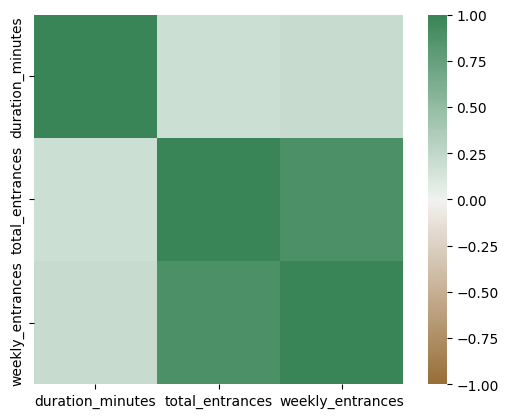

In [19]:
# df pour la heatmap
df_pearson = df.copy()
df_pearson = df.dropna()[['duration_minutes', 'total_entrances', 'weekly_entrances']]
corr_df_pearon = df_pearson.corr()
print (corr_df_pearon)

axis_corr = sns.heatmap(
corr_df_pearon,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True
)

plt.show()

In [20]:

# Exemple de dataframe df_2_anova
df_2_anova = df[['country', 'category', 'released_year', 'date', 'PEGI', 'weekly_entrances']]

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
        # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
        # if p_value < 0.05:
        #     # Appliquer le test post-hoc Tukey
        #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
        #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour country
Statistique F: 8.923121507068474
P-value: 1.7635876675343618e-92

Le résultat pour category
Statistique F: 76.77469402431032
P-value: 0.0

Le résultat pour released_year
Statistique F: 3.46729591510135
P-value: 1.3117317452362457e-15

Le résultat pour date
Statistique F: 1.048856544897949
P-value: 0.09655942615591387

Le résultat pour PEGI
Statistique F: 12.461635919383431
P-value: 4.421275745310439e-12



### Les variables explicatives

## 1. ANOVA

Avec le test de l'ANOVA on remarquer que les variables explicatives ont :

- le réalisateur
- le pays 
- la catégorie
- l'année de sortie
- le pegi

# 2. Corrélation de pearson

il y a une vrai variale qui peut explicative et , qui est la durée du film l'autre est une fuite de données pour un modele qui prédit la premiere semaine d'entrées

# 3. analyse approfondie 

pour le test de l'Anova les tests post-hoc étant une comparaison entre chaque catégories, il y a beaucoup de categories ce qui les tableaux trop volumineux pour etre comparer



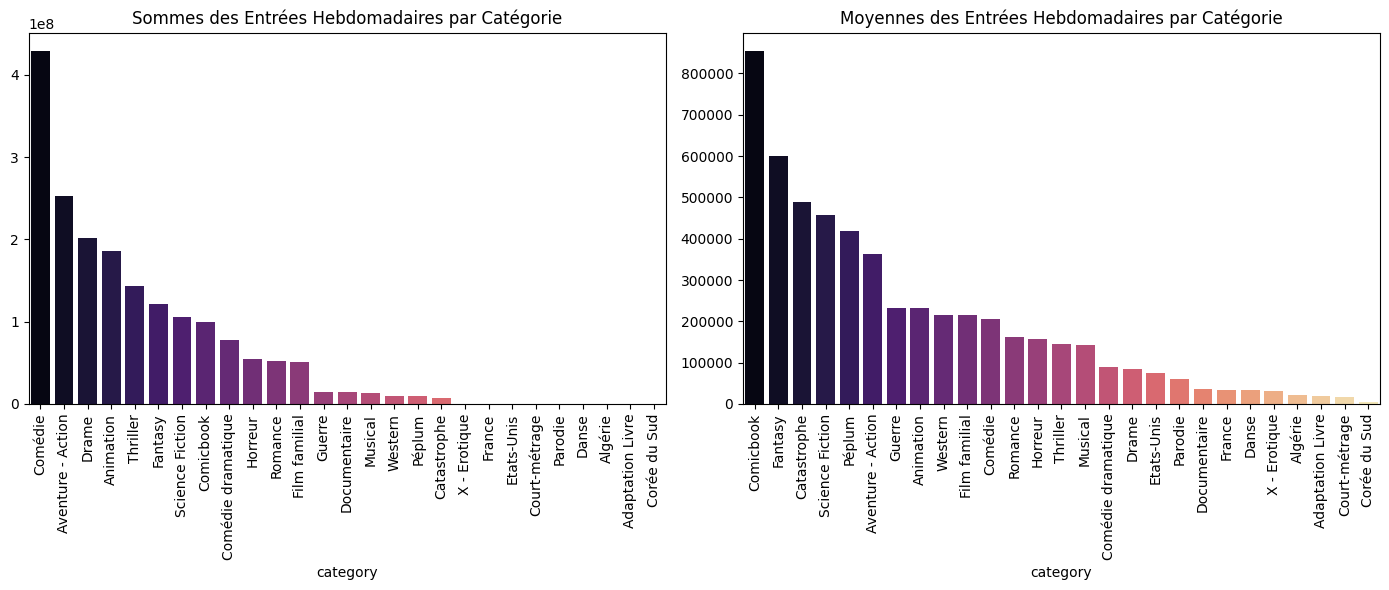

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


df_we_sum = df.groupby('category')['weekly_entrances'].sum().sort_values(ascending=False)

df_we_mean = df.groupby('category')['weekly_entrances'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_sum.index, y=df_we_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par Catégorie')
axes[0].set_xticklabels(df_we_sum.index, rotation=90)


sns.barplot(x=df_we_mean.index, y=df_we_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par Catégorie')
axes[1].set_xticklabels(df_we_mean.index, rotation=90)
plt.tight_layout()
plt.show()


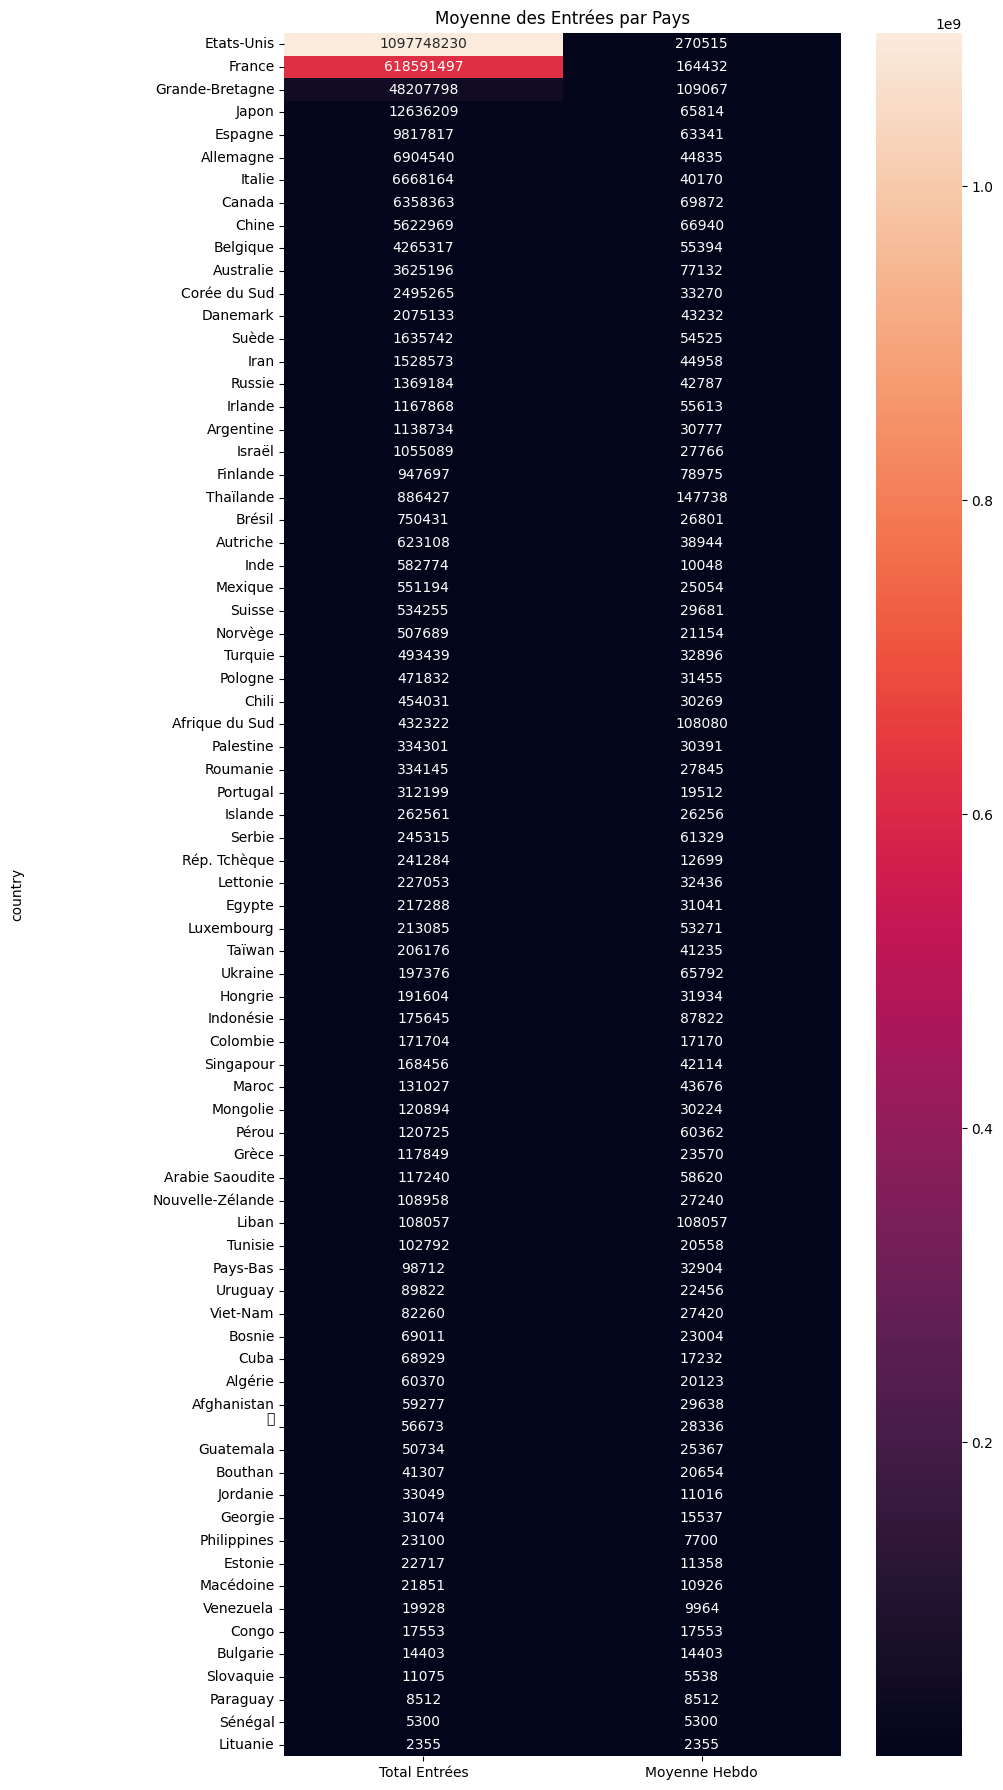

In [22]:
# un tableau est plus pertinent dans ce cas

df_we_country_sum = df.groupby('country')['weekly_entrances'].sum().sort_values(ascending=False)

df_we_country_mean = df.groupby('country')['weekly_entrances'].mean().sort_values(ascending=False)

df_country_stats = pd.concat(
    [df_we_country_sum, df_we_country_mean],
    axis=1,
    keys=['Total Entrées', 'Moyenne Hebdo']
)

plt.figure(figsize=(10, 18))
sns.heatmap(df_country_stats.sort_values('Total Entrées', ascending=False), annot=True, fmt=".0f")
plt.title('Moyenne des Entrées par Pays')
plt.tight_layout()
plt.show()

### attention la palette ne respecte pas l'échelle

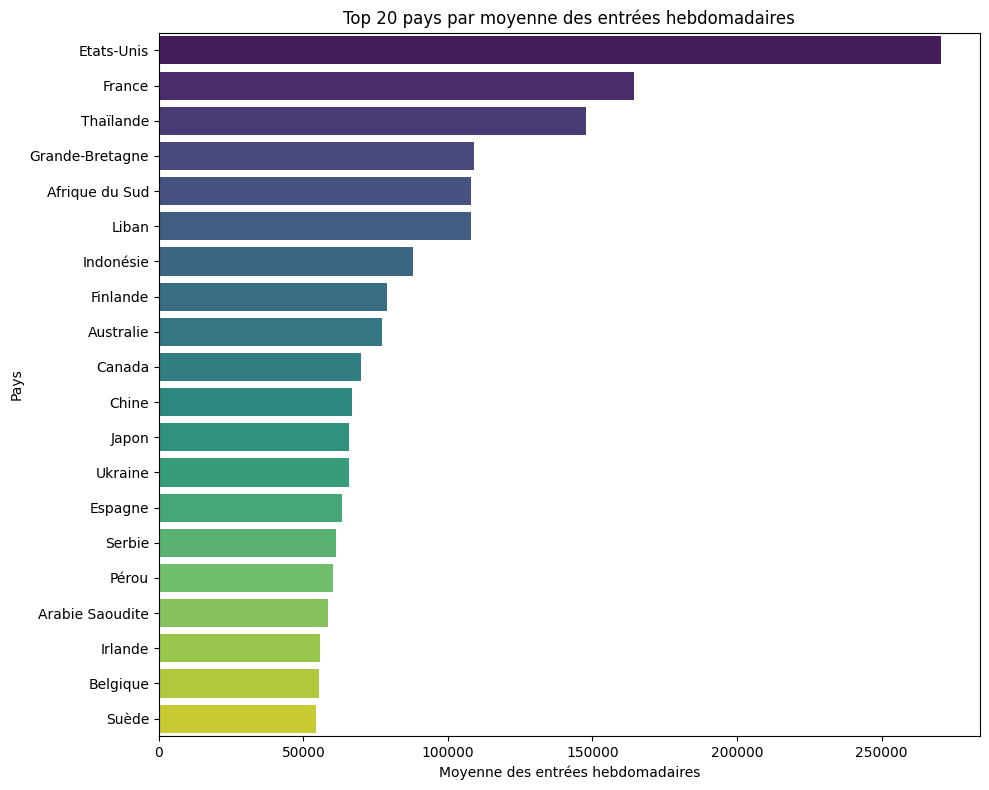

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# On prend les 20 pays avec les meilleures moyennes
top_n = 20
df_top_mean = df_we_country_mean.head(top_n)

# Tracer un bar chart horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_mean.values, y=df_top_mean.index, palette="viridis")
plt.title(f'Top {top_n} pays par moyenne des entrées hebdomadaires')
plt.xlabel('Moyenne des entrées hebdomadaires')
plt.ylabel('Pays')
plt.tight_layout()
plt.show()


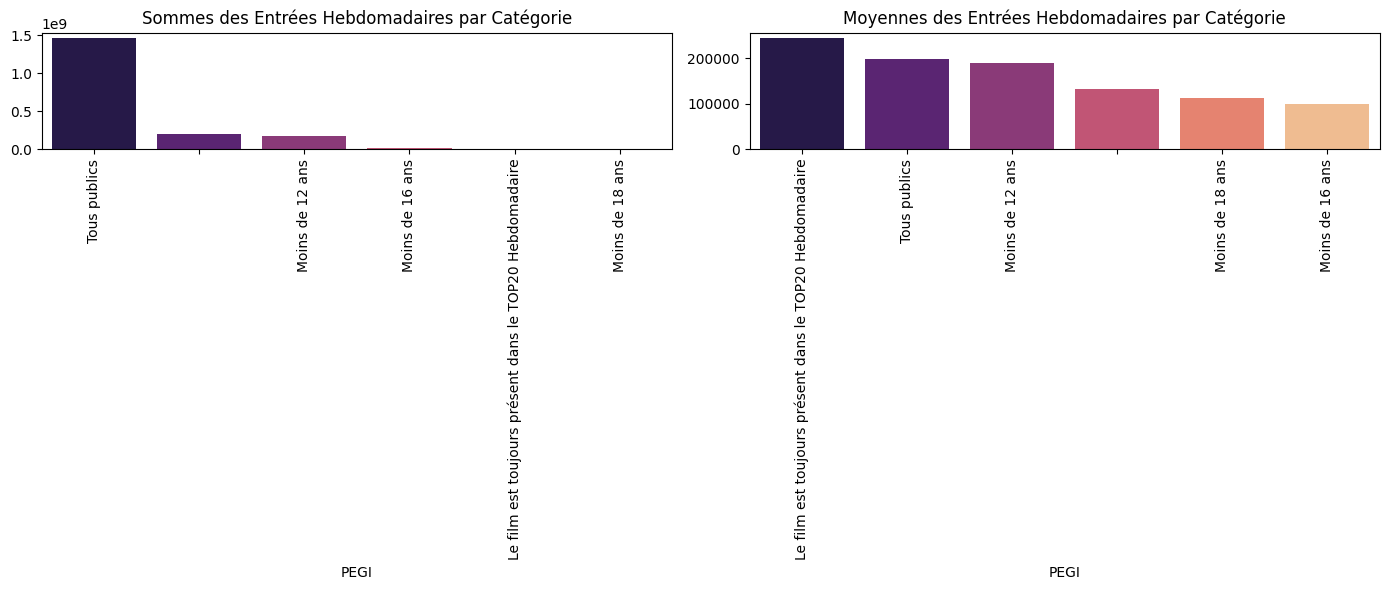

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


df_we_PEGI_sum = df.groupby('PEGI')['weekly_entrances'].sum().sort_values(ascending=False)

df_we_PEGI_mean = df.groupby('PEGI')['weekly_entrances'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_PEGI_sum.index, y=df_we_PEGI_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par Catégorie')
axes[0].set_xticklabels(df_we_PEGI_sum.index, rotation=90)


sns.barplot(x=df_we_PEGI_mean.index, y=df_we_PEGI_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par Catégorie')
axes[1].set_xticklabels(df_we_PEGI_mean.index, rotation=90)
plt.tight_layout()
plt.show()

In [25]:
df.groupby('PEGI')['PEGI'].count()

PEGI
                                                           1522
Le film est toujours présent dans le TOP20 Hebdomadaire      12
Moins de 12 ans                                             886
Moins de 16 ans                                             153
Moins de 18 ans                                               7
Tous publics                                               7391
Name: PEGI, dtype: int64

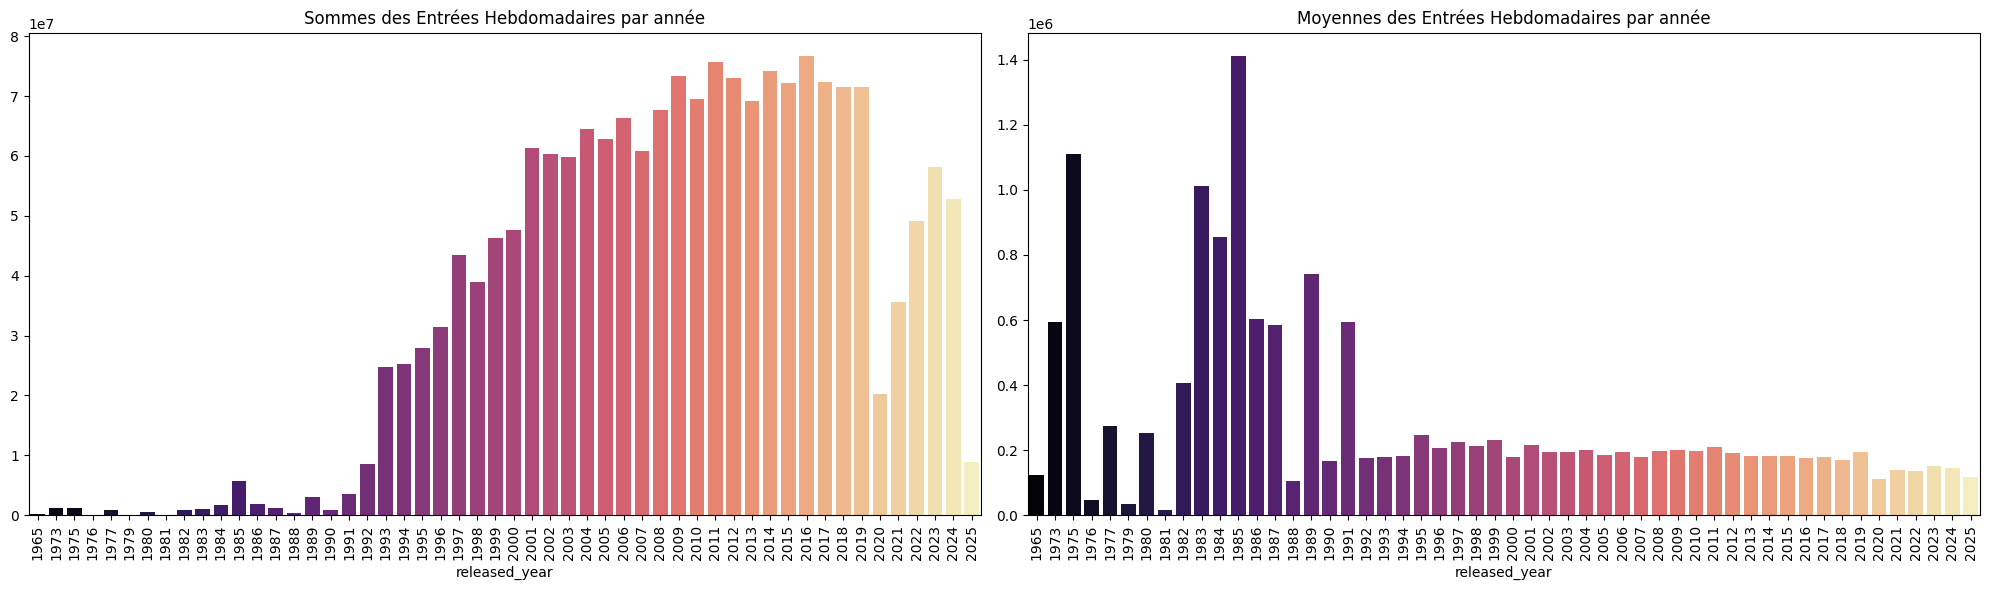

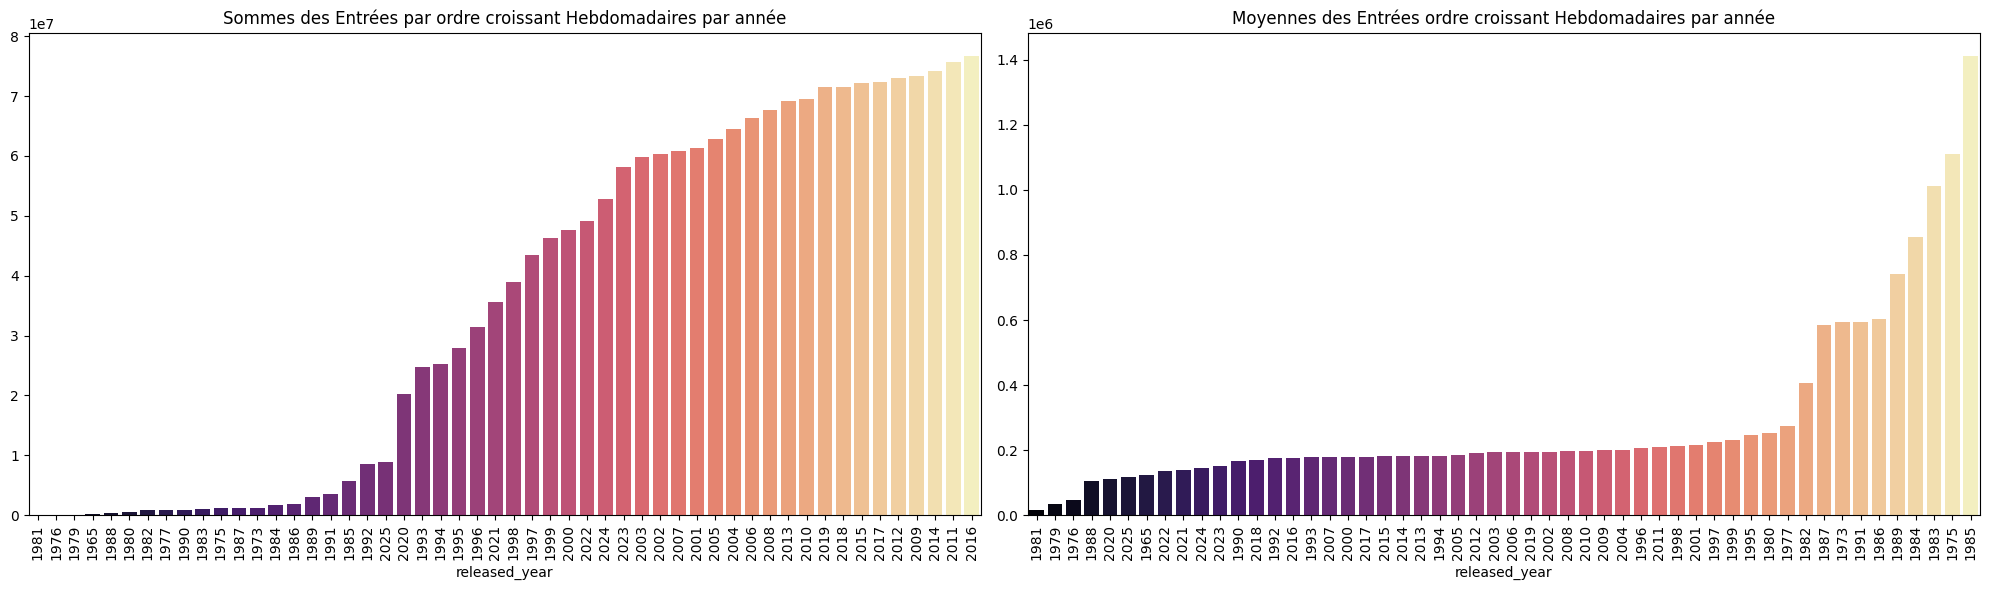

In [26]:
df_we_years_sum = df.groupby('released_year')['weekly_entrances'].sum()
df_we_years_mean = df.groupby('released_year')['weekly_entrances'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x=df_we_years_sum.index, y=df_we_years_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum.index, rotation=90)


sns.barplot(x=df_we_years_mean.index, y=df_we_years_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean.index, rotation=90)
plt.tight_layout()
plt.show()

df_we_years_sum_ORDER = df.groupby('released_year')['weekly_entrances'].sum().sort_values()
df_we_years_mean_ORDER = df.groupby('released_year')['weekly_entrances'].mean().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x=df_we_years_sum_ORDER.index, y=df_we_years_sum_ORDER.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées par ordre croissant Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum_ORDER.index, rotation=90)


print('='*550)

sns.barplot(x=df_we_years_mean_ORDER.index, y=df_we_years_mean_ORDER.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées ordre croissant Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean_ORDER.index, rotation=90)
plt.tight_layout()
plt.show()




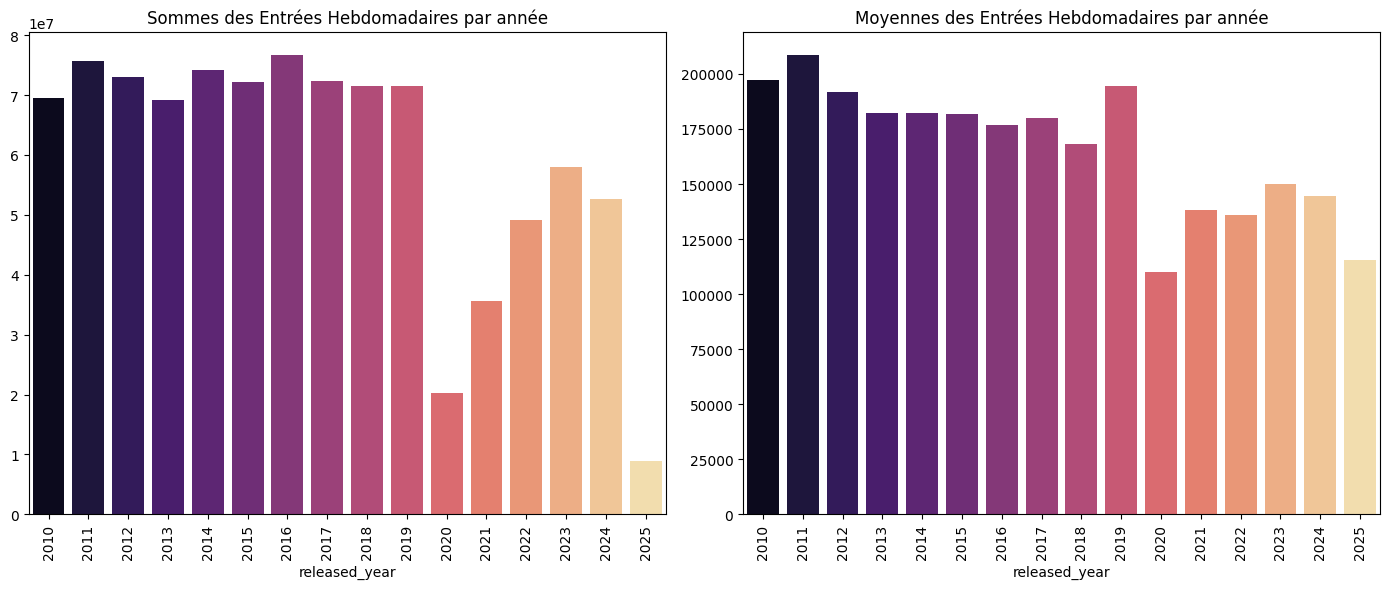

In [27]:

#AFFLUENCE PAR ANNEE À PARTIR DE 2010

df_year_2010 = df[['released_year','weekly_entrances']][pd.to_numeric(df['released_year']) > 2009]
# df_year_2010

df_we_years_sum = df_year_2010.groupby('released_year')['weekly_entrances'].sum()
df_we_years_mean = df_year_2010.groupby('released_year')['weekly_entrances'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_we_years_sum.index, y=df_we_years_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par année')
axes[0].set_xticklabels(df_we_years_sum.index, rotation=90)


sns.barplot(x=df_we_years_mean.index, y=df_we_years_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par année')
axes[1].set_xticklabels(df_we_years_mean.index, rotation=90)
plt.tight_layout()
plt.show()


In [93]:
df.columns

Index(['fr_title', 'original_title', 'director', 'country', 'category',
       'released_year', 'date', 'PEGI', 'duration', 'total_entrances',
       'weekly_entrances', 'duration_minutes'],
      dtype='object')

In [108]:
df.columns

Index(['fr_title', 'original_title', 'director', 'country', 'category',
       'released_year', 'date', 'PEGI', 'duration', 'total_entrances',
       'weekly_entrances', 'duration_minutes'],
      dtype='object')

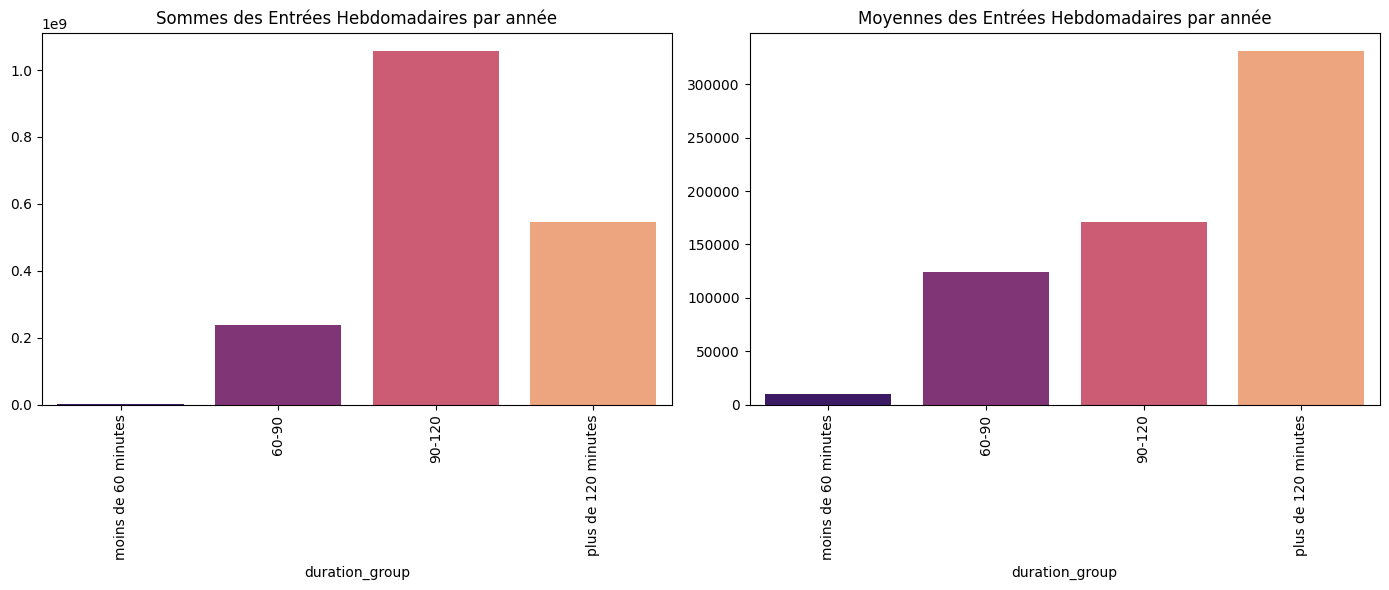

In [30]:
bins_duration = [0,60,90,120,df ['duration_minutes'].max()]
bins_duration_label = ['moins de 60 minutes','60-90','90-120','plus de 120 minutes']
df_duration = df[['duration_minutes','weekly_entrances']]

df_duration['duration_group'] = pd.cut(df_duration['duration_minutes'],bins_duration,labels = bins_duration_label)

df_duration_sum = df_duration.groupby('duration_group')['weekly_entrances'].sum()
df_duration_mean = df_duration.groupby('duration_group')['weekly_entrances'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=df_duration_sum.index, y=df_duration_sum.values, palette='magma', ax=axes[0])
axes[0].set_title('Sommes des Entrées Hebdomadaires par année')
axes[0].set_xticklabels(df_duration_sum.index, rotation=90)


sns.barplot(x=df_duration_mean.index, y=df_duration_mean.values, palette='magma', ax=axes[1])
axes[1].set_title('Moyennes des Entrées Hebdomadaires par année')
axes[1].set_xticklabels(df_duration_mean.index, rotation=90)
plt.tight_layout()
plt.show()



In [31]:
#  répartition des film par la catégorie de durée

df_duration = df.copy()

df_duration['duration_group'] = pd.cut(df_duration['duration_minutes'],bins_duration,labels = bins_duration_label)

df_duration.groupby('duration_group')['original_title'].count()

duration_group
moins de 60 minutes     172
60-90                  1909
90-120                 6198
plus de 120 minutes    1645
Name: original_title, dtype: int64

In [ ]:
df.columns

Index(['fr_title', 'original_title', 'director', 'country', 'category',
       'released_year', 'date', 'PEGI', 'duration', 'total_entrances',
       'weekly_entrances', 'duration_minutes'],
      dtype='object')

In [46]:
df[['original_title','fr_title','released_year']][df['original_title'].duplicated() == True]

,original_title,fr_title,released_year
3672,Alive,Les Survivants,1993
